In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr

from shapely.geometry import Point

In [2]:
filepath = '../data/raw/cdl_apples_northeastern.TIF'

In [3]:
def load_cdl(filepath):
    """
    Load a raster file, create points from valid pixel values, and convert to a GeoDataFrame in EPSG:4326.
    
    Args:
        filepath (str): The file path to the raster file.
        
    Returns:
        GeoDataFrame: A GeoDataFrame containing point geometries for valid pixel values, 
                      with coordinates in EPSG:4326.
    """
    with rio.open(filepath) as src:
        # Read the first band with masking
        image = src.read(1, masked=True)

        # Get row, column indices for valid pixel values
        rows, cols = np.where(image < 255)

        # Create point geometries using affine transformation
        transform = src.transform
        geoms = [Point(transform * (col, row)) for row, col in zip(rows, cols)]

        # Create GeoDataFrame with the correct coordinate reference system
        gdf = gpd.GeoDataFrame(geometry=geoms, crs=src.crs)

    # Return GeoDataFrame in EPSG:4326
    return gdf.to_crs('EPSG:4326')

In [6]:
gdf = load_cdl(filepath)

<Axes: >

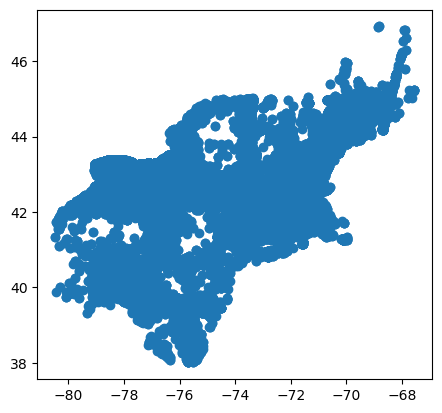

In [7]:
gdf.plot()